In [1]:
import deepchem as dc
import numpy as np
import pandas as pd
import torch

import warnings
warnings.filterwarnings("once")

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
/home/rmrr/.conda/envs/deepchem/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Anno

In [2]:
dc.__version__

'2.8.0'

In [3]:
N_samples = 50
n_features = 10
X = np.random.rand(N_samples, n_features)
y = np.random.rand(N_samples)
dataset = dc.data.NumpyDataset(X, y)
dataset.X.shape, dataset.y.shape

((50, 10), (50,))

In [4]:
smiles = [
  'O=Cc1ccc(O)c(OC)c1',
  'CN1CCC[C@H]1c2cccnc2',
  'C1CCCCC1',
  'c1ccccc1',
  'CC(=O)O',
]

properties = [0.4, -1.5, 3.2, -0.2, 1.7]
featurizer = dc.feat.CircularFingerprint(size=1024)
ecfp = featurizer.featurize(smiles)
ecfp.shape

[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator


(5, 1024)

In [5]:
# make a dataframe object for creating a CSV file
df = pd.DataFrame(list(zip(smiles, properties)), columns=["SMILES", "property"])

import tempfile

with dc.utils.UniversalNamedTemporaryFile(mode='w') as tmpfile:
  # dump the CSV file
  df.to_csv(tmpfile.name)
  # initizalize the featurizer
  featurizer = dc.feat.CircularFingerprint(size=1024)
  # initizalize the dataloader
  loader = dc.data.CSVLoader(["property"], feature_field="SMILES", featurizer=featurizer)
  # load and featurize the data from the CSV file
  dataset = loader.create_dataset(tmpfile.name)
    
len(dataset)

[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator
[16:13:14] DEPRECATION WARNING: please use MorganGenerator


5

In [6]:
splitter = dc.splits.RandomSplitter()

# split 5 datapoints in the ratio of train:valid:test = 3:1:1
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
  dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2
)
len(train_dataset), len(valid_dataset), len(test_dataset)

(3, 1, 1)

In [7]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
model = dc.models.SklearnModel(model=rf)

# model training
model.fit(train_dataset)
valid_preds = model.predict(valid_dataset)
test_preds = model.predict(test_dataset)
valid_preds.shape, test_preds.shape 

((1,), (1,))

In [8]:
# initialze the metric
metric = dc.metrics.Metric(dc.metrics.mae_score)

# evaluate the model
train_score = model.evaluate(train_dataset, [metric])
valid_score = model.evaluate(valid_dataset, [metric])
test_score = model.evaluate(test_dataset, [metric])

train_score, valid_score, test_score

({'mae_score': 0.7470000000000008},
 {'mae_score': 1.2359999999999993},
 {'mae_score': 2.169999999999998})

# Solubility Dataset

In [58]:
import deepchem as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch

import sys
import logging
logger = logging.getLogger()
logger.addHandler(logging.StreamHandler(stream=sys.stdout))
logger.info("test")

import warnings
warnings.filterwarnings("once")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [246]:
# TODO: experiment with different featurizers/splitters/transformers
FEATURIZER = dc.feat.MolGraphConvFeaturizer(use_edges=True)
SPLITTER = dc.splits.RandomSplitter()
# SPLITTER = dc.splits.RandomStratifiedSplitter()
TRANSFORMERS = ["normalization"]

In [247]:
# function to load in the delaney dataset with specified featurizer
# dastaset initially consists of consists of (cid, smiles, log-solubility) tuples
def load_featurised_dataset(featurizer, splitter, transformers, **kwargs):
    tasks, datasets, transformers = dc.molnet.load_delaney(featurizer=featurizer, 
                                                           splitter=splitter,
                                                           transformers=transformers,
                                                           reload=True,
                                                           data_dir="data",
                                                           save_dir="data",
                                                           **kwargs)
    return tasks, datasets, transformers

In [248]:
# loading in featurised dataset 
tasks, datasets, transformers = load_featurised_dataset(FEATURIZER,
                                                        SPLITTER,
                                                        TRANSFORMERS,
                                                        seed=42,
                                                        log_every_n=100,
                                                        frac_train=0.8,
                                                        frac_valid=0.1,
                                                        frac_test=0.1)

train_dataset, valid_dataset, test_dataset = datasets

In [249]:
train_dataset.X.shape, valid_dataset.X.shape, test_dataset.X.shape

((901,), (113,), (113,))

(-2.4644240280247647e-16, 0.9999999999999997)

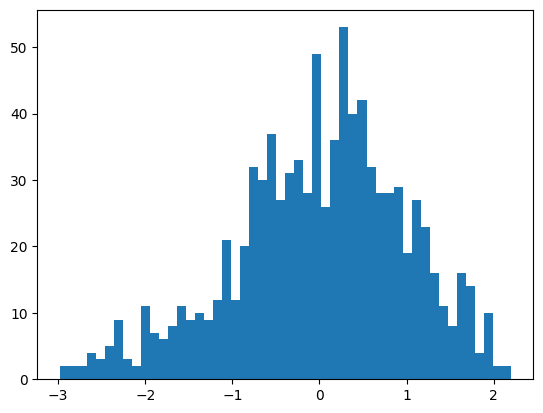

In [250]:
plt.hist(train_dataset.y, bins=50);
train_dataset.y.mean(), train_dataset.y.std()

In [251]:
LOSS = dc.models.losses.L2Loss()
OPTIMIZER = dc.models.optimizers.Adam()
BATCH_SIZE = 64
MAX_EPOCHS = 200

model = dc.models.torch_models.MPNNModel(n_tasks=1,
                                         mode='regression', 
                                         node_out_feats=64,
                                         edge_hidden_feats=128,
                                         num_step_message_passing=3,
                                         num_step_set2set=6,
                                         num_layer_set2set=3,
                                         number_atom_features=30,
                                         number_bond_features=11,
                                         batch_size=BATCH_SIZE,
                                         device="cpu",
                                         optimizer=OPTIMIZER,
                                         #learning_rate=0.001,
                                         log_frequency=1,
                                         model_dir="model",)

In [252]:
from math import ceil

train_losses = []
train_errors = []
valid_errors = []
batches_per_epoch = ceil(train_dataset.X.shape[0] / BATCH_SIZE)

In [253]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [254]:
early_stopper = EarlyStopper(patience=16, min_delta=0)

for epoch in range(1, MAX_EPOCHS):
    # train model 1 epoch
    batch_generator = model.default_generator(train_dataset,
                                              epochs=1,
                                              mode="fit",
                                              deterministic=False,
                                              pad_batches=False)
    loss = model.fit_generator(batch_generator, all_losses=train_losses,) # appends losses to train_losses

    # track stats
    
    # print(f"{epoch:3d}/{N_EPOCHS:3d}: {sum(train_losses[-batches_per_epoch:]) / batches_per_epoch}")
    train_mse = model.evaluate(train_dataset, metrics, transformers)["mean_squared_error"]
    valid_mse = model.evaluate(valid_dataset, metrics, transformers)["mean_squared_error"]
    
    if epoch == 1:
        print(f"Epoch {epoch:3d} | {valid_mse:.4f} | {early_stopper.counter:2d}")
    else:
        print(f"Epoch {epoch:3d} | {valid_errors[-1]:.4f} --> {valid_mse:.4f} | {early_stopper.counter:2d}")
        
    train_errors.append(train_mse)
    valid_errors.append(valid_mse)

    # check for early stop
    if early_stopper.early_stop(valid_mse):
        break

Epoch   1 | 3.8780 |  0
Epoch   2 | 3.8780 --> 3.6928 |  0
Epoch   3 | 3.6928 --> 2.7903 |  0
Epoch   4 | 2.7903 --> 2.3790 |  0
Epoch   5 | 2.3790 --> 1.9869 |  0
Epoch   6 | 1.9869 --> 2.0024 |  0
Epoch   7 | 2.0024 --> 1.7105 |  1
Epoch   8 | 1.7105 --> 1.7135 |  0
Epoch   9 | 1.7135 --> 2.0794 |  1
Epoch  10 | 2.0794 --> 1.1728 |  2
Epoch  11 | 1.1728 --> 1.6262 |  0
Epoch  12 | 1.6262 --> 1.2425 |  1
Epoch  13 | 1.2425 --> 0.9879 |  2
Epoch  14 | 0.9879 --> 1.3319 |  0
Epoch  15 | 1.3319 --> 1.8055 |  1
Epoch  16 | 1.8055 --> 1.1442 |  2
Epoch  17 | 1.1442 --> 1.0122 |  3
Epoch  18 | 1.0122 --> 0.8267 |  4
Epoch  19 | 0.8267 --> 0.8210 |  0
Epoch  20 | 0.8210 --> 1.1335 |  0
Epoch  21 | 1.1335 --> 0.7290 |  1
Epoch  22 | 0.7290 --> 0.6943 |  0
Epoch  23 | 0.6943 --> 1.0656 |  0
Epoch  24 | 1.0656 --> 1.3910 |  1
Epoch  25 | 1.3910 --> 0.7846 |  2
Epoch  26 | 0.7846 --> 0.8906 |  3
Epoch  27 | 0.8906 --> 0.7409 |  4
Epoch  28 | 0.7409 --> 0.6975 |  5
Epoch  29 | 0.6975 --> 0.6941 |

In [217]:
print(f"Total training batches: {model.get_global_step()}")

Total training batches: 915


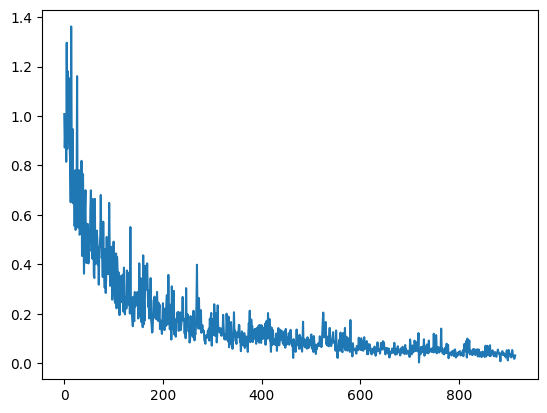

In [218]:
plt.plot(train_losses)

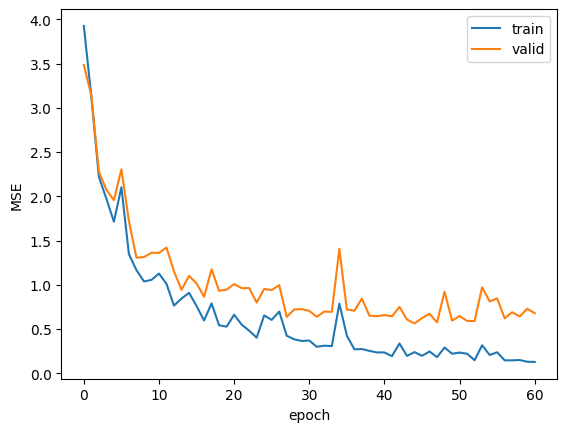

In [219]:
plt.plot(train_errors, label="train")
plt.plot(valid_errors, label="valid")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.show()

In [243]:
# METRICS = [dc.metrics.Metric(dc.metrics.mean_absolute_error), 
#            dc.metrics.Metric(dc.metrics.mean_squared_error)]
METRICS = [dc.metrics.Metric(dc.metrics.rms_score),
           dc.metrics.Metric(dc.metrics.mean_absolute_error),
           dc.metrics.Metric(dc.metrics.r2_score),]
split_to_dataset = dict(train=train_dataset,
                        valid=valid_dataset,
                        test=test_dataset)

def split_error(model, metrics, transformers):
    for split in "train", "valid", "test":
        dataset = split_to_dataset[split]
        y_true = transformers[0].untransform(dataset.y)
        y_pred = transformers[0].untransform(model.predict_on_batch(dataset.X))
        results = {metric: round(v, 5) for metric, v in model.evaluate(dataset, metrics, transformers).items()}
        print(f"{split}: {results} += {((y_true - y_pred)**2).std():.5f}")

In [244]:
split_error(model, METRICS, transformers)

train: {'rms_score': 0.35806, 'mean_absolute_error': 0.273, 'r2_score': 0.97084} += 0.21364
valid: {'rms_score': 0.82372, 'mean_absolute_error': 0.60554, 'r2_score': 0.8281} += 1.26631
test: {'rms_score': 0.85374, 'mean_absolute_error': 0.63522, 'r2_score': 0.84778} += 1.35141


## Benchmarking

### MPNN Model

MPNN default (RandomSplitter):
train: {'mean_squared_error': 0.13890272648743807} +- 0.26452
valid: {'mean_squared_error': 0.5141257825522936} +- 0.86895
test: {'mean_squared_error': 0.7261491458366378} +- 2.22714

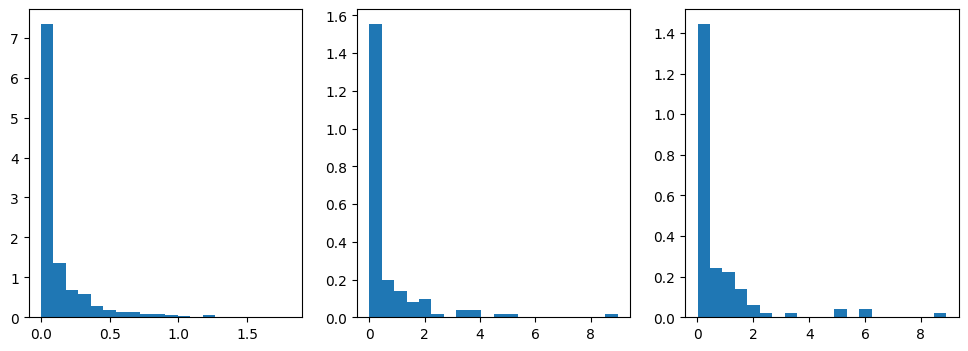

In [245]:
fig = plt.figure(figsize=(12, 4))
axs = fig.subplots(1, 3)

for i, split in enumerate(("train", "valid", "test")):
    dataset = split_to_dataset[split]
    y_true = transformers[0].untransform(dataset.y)
    y_pred = transformers[0].untransform(model.predict_on_batch(dataset.X))
    squared_errors = (y_true - y_pred)**2
    axs[i].hist(squared_errors, bins=20, density=True)

In [231]:
y_pred = model.predict_on_batch(test_dataset.X[:16])
for molecule, y_true, y_pred in zip(test_dataset.ids, test_dataset.y, y_pred):
    log_sol_true = transformers[0].untransform(y_true).item()
    log_sol_pred = transformers[0].untransform(y_pred).item()
    sol_true = np.exp(log_sol_true)
    sol_pred = np.exp(log_sol_pred)
    print(f"{molecule:60}: {log_sol_true:.4f} ({sol_true:.4f}), {log_sol_pred:.4f} ({sol_pred:.4f})")

ClC4=C(Cl)C5(Cl)C3C1CC(C2OC12)C3C4(Cl)C5(Cl)Cl              : -6.2900 (0.0019), -6.6737 (0.0013)
CCCCCCCC(=O)OC                                              : -3.1700 (0.0420), -2.8783 (0.0562)
CN(C)C(=O)SCCCCOc1ccccc1                                    : -3.9270 (0.0197), -2.6222 (0.0726)
CCCCCCCI                                                    : -4.8100 (0.0081), -5.3164 (0.0049)
CC(C)OC=O                                                   : -0.6300 (0.5326), -0.2456 (0.7822)
c1ccccc1n2ncc(N)c(Br)c2(=O)                                 : -3.1270 (0.0438), -0.7096 (0.4919)
Cc1ccc(C)c2ccccc12                                          : -4.1400 (0.0159), -4.5145 (0.0109)
Cc1cc2c3ccccc3ccc2c4ccccc14                                 : -6.5700 (0.0014), -7.9646 (0.0003)
CCC(Br)(CC)C(=O)NC(N)=O                                     : -2.6800 (0.0686), -1.6996 (0.1828)
O=C2CN(N=Cc1ccc(o1)N(=O)=O)C(=O)N2                          : -3.3800 (0.0340), -1.5253 (0.2176)
CC(C)C(C(=O)OC(C#N)c1cccc(Oc2c

In [28]:
import os
os.environ['DEEPCHEM_DATA_DIR'] = "/home/rmrr/career/uncountable/data"

featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
splitter = "random"
# splitter = dc.splits.MolecularWeightSplitter()
transformers = ["normalization"]

tasks, datasets, transformers = dc.molnet.load_qm9(featurizer=featurizer, 
                                                   splitter=splitter,
                                                   transformers=transformers,
                                                   reload=True,
                                                   data_dir="data",
                                                   save_dir="data")

train_dataset, valid_dataset, test_dataset = datasets

In [30]:
train_dataset.get_shape()

((105576,), (105576, 12), (105576, 12), (105576,))

In [32]:
import wandb
from deepchem.models import WandbLogger

os.environ["WANDB_API_KEY"] = "#####"
wandb_logger = WandbLogger(project="deepchem")

In [33]:
BATCH_SIZE=32
# wandb_logger.experiment.config["batch_size"] = BATCH_SIZE

In [34]:
model = dc.models.torch_models.MPNNModel(n_tasks=1,
                                         node_out_feats = 64,
                                         edge_hidden_feats = 128,
                                         num_step_message_passing = 3,
                                         num_step_set2set = 6,
                                         num_layer_set2set = 3,
                                         mode = 'regression',
                                         number_atom_features = 30,
                                         number_bond_features = 11,
                                         self_loop= False,
                                         batch_size=BATCH_SIZE,
                                         model_dir="model",
                                         # wandb=True,
                                         learning_rate=0.001, 
                                         device="cpu",
                                         wandb_logger=wandb_logger)

In [35]:
loss = model.fit(train_dataset,
                 nb_epoch=10,
                 restore=False)

/home/rmrr/.conda/envs/deepchem/lib/python3.11/site-packages/deepchem/models/losses.py:90: UserWarning: Using a target size (torch.Size([32, 12])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return torch.nn.functional.mse_loss(output,
/home/rmrr/.conda/envs/deepchem/lib/python3.11/multiprocessing/pool.py:268: ResourceWarning: unclosed running multiprocessing pool <multiprocessing.pool.ThreadPool state=RUN pool_size=1>
  _warn(f"unclosed running multiprocessing pool {self!r}",


KeyboardInterrupt: 

In [12]:
loss

0.2532390818876379

In [13]:
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.8369425954252208}
Test set score: {'pearson_r2_score': 0.6213956040328277}


In [15]:
solubilities = model.predict_on_batch(test_dataset.X[:10])
for molecule, y_pred, y in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(y_pred, y, molecule)

[-1.376157] [-1.60000553] c1cc2ccc3cccc4ccc(c1)c2c34
[0.52692] [0.20952792] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.68075764] [-0.01497035] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-1.6134826] [-2.82071486] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.1654787] [-0.52783277] C1=Cc2cccc3cccc1c23
[1.6020465] [1.10268267] CC1CO1
[-0.6525793] [-0.88877179] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-0.7522491] [-0.52541361] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-0.32961416] [-0.76249152] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.8767008] [-0.63911424] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
